<a href="https://colab.research.google.com/github/radrams/child_malnutrition/blob/master/Underweight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import scipy.stats as stats
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from statsmodels.compat import scipy
import statsmodels.api as sm
import os

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

np.random.seed(42)
random.seed(42)
warnings.filterwarnings('ignore')

path = "https://github.com/radrams/child_malnutrition/raw/master/data/underweight.xlsx"

############## Read from Excel file ######################################################
# Read the data
df_immu_hyg_underweight = pd.read_excel(path, sheet_name='underweight')
# Print Column names
print(df_immu_hyg_underweight.head())
# print(df_immu_hyg_underweight.columns.ravel())
print('===============================================================')
print(df_immu_hyg_underweight.describe())
print('===============================================================')
print(df_immu_hyg_underweight.isnull().sum())
print('===============================================================')

   SH.H2O.BASW.ZS  SH.H2O.SMDW.ZS  SH.IMM.HEPB  SH.IMM.HIB3  SH.IMM.IBCG  SH.IMM.IDPT  SH.IMM.MEAS  SH.IMM.POL3  SH.MLR.IPTP.ZS  SH.MLR.NETS.ZS  SH.MLR.TRET.ZS  SH.STA.ARIC.ZS  SH.STA.BASS.ZS  SH.STA.HYGN.ZS  SH.STA.ORCF.ZS  SH.STA.ORTH  SH.STA.SMSS.ZS  SH.STA.MALN.ZS
0       75.652997             NaN         65.0          NaN         81.0         75.0         76.0         72.0             NaN             0.0             4.0             NaN       41.087505             NaN            43.2          NaN             NaN            61.0
1       78.482299             NaN         64.0          NaN         83.0         71.0         74.0         80.0             NaN             NaN             0.7            61.0       46.720874             NaN            35.5          NaN             NaN            56.0
2       81.955787             NaN         76.0          NaN         83.0         73.0         76.0         77.0             NaN             3.0             0.8            66.0       54.299143  

In [17]:
############ Drop Columns having 'na' count greater than 150 rows =================
max_number_of_nas = 150
df_immu_hyg_underweight = df_immu_hyg_underweight.loc[:, (df_immu_hyg_underweight.isnull().sum(axis=0) <= max_number_of_nas)]
############################################### MISSING VALUES #############6############################################
# Number of missing values
print('===================== Missing Values Summary Before Imputation =====================')
print(df_immu_hyg_underweight.isnull().sum())
print('===============================================================')

############################################### Handling missing values using mean imputation
df_immu_hyg_underweight.fillna(df_immu_hyg_underweight.mean(), inplace=True)
print('===================== Missing Values Summary After Imputation =====================')
print(df_immu_hyg_underweight.isnull().sum())
print('===============================================================')

===================== Missing Values Summary Before Imputation =====================
SH.H2O.BASW.ZS     28
SH.IMM.HEPB        68
SH.IMM.HIB3       141
SH.IMM.IBCG        10
SH.IMM.IDPT        10
SH.IMM.MEAS        10
SH.IMM.POL3        10
SH.STA.BASS.ZS     29
SH.STA.MALN.ZS      0
dtype: int64
===================== Missing Values Summary After Imputation =====================
SH.H2O.BASW.ZS    0
SH.IMM.HEPB       0
SH.IMM.HIB3       0
SH.IMM.IBCG       0
SH.IMM.IDPT       0
SH.IMM.MEAS       0
SH.IMM.POL3       0
SH.STA.BASS.ZS    0
SH.STA.MALN.ZS    0
dtype: int64


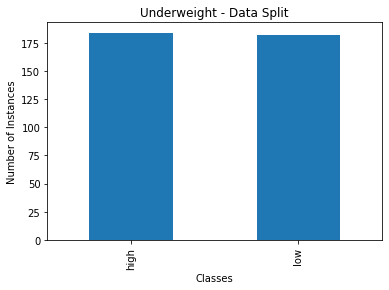

In [18]:
########################################### Defining input and output columns
X = df_immu_hyg_underweight.loc[:, df_immu_hyg_underweight.columns != 'SH.STA.MALN.ZS']

################# Grouping Data
median_split = df_immu_hyg_underweight['SH.STA.MALN.ZS'].median()
y = pd.cut(df_immu_hyg_underweight['SH.STA.MALN.ZS'], bins=[0, median_split, 100], right=False, labels=['low', 'high'])
y.value_counts().plot(kind='bar')
plt.title("Underweight - Data Split")
plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.show()
###################################################################################################

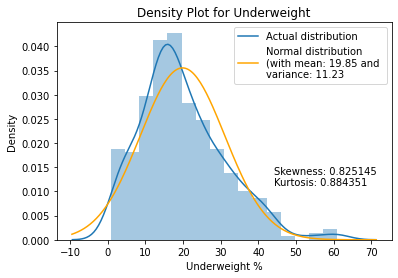

In [19]:
############################################## Distribution plot
f, ax = plt.subplots(1, sharex=True)
mean_value = df_immu_hyg_underweight['SH.STA.MALN.ZS'].mean()
std_value = df_immu_hyg_underweight['SH.STA.MALN.ZS'].std()
sns.distplot(df_immu_hyg_underweight['SH.STA.MALN.ZS'], kde_kws={"label": "Actual distribution"},
             fit=stats.norm, fit_kws={"label": "Normal distribution\n(with mean: {:0.2f} and \nvariance: {:0.2f}"
                                               .format(mean_value, std_value), "color":"orange"})
plt.title('Density Plot for Underweight')
plt.xlabel('Underweight %')
plt.ylabel('Density')
plt.legend(loc="upper right")
f.text(x=0.65, y=0.3,  transform = ax.transAxes, s="Skewness: {:0.6f}".format(df_immu_hyg_underweight['SH.STA.MALN.ZS'].skew()))
f.text(x=0.65, y=0.25, transform = ax.transAxes, s="Kurtosis: {:0.6f}".format(df_immu_hyg_underweight['SH.STA.MALN.ZS'].kurt()))
plt.show()

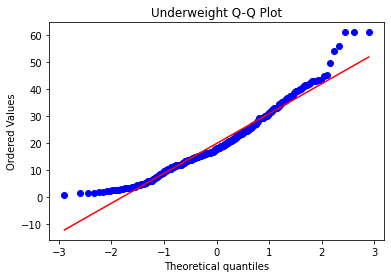

In [20]:
############ Q-Q Plot
stats.probplot(df_immu_hyg_underweight['SH.STA.MALN.ZS'], dist="norm", plot=plt)
plt.title("Underweight Q-Q Plot")
plt.show()

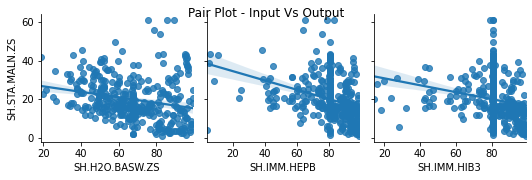

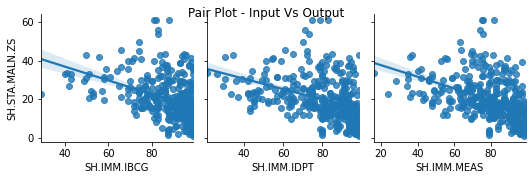

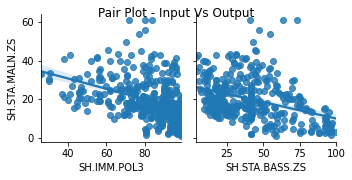

In [21]:
########### Pairplot
g = sns.pairplot(df_immu_hyg_underweight, x_vars=X.columns[0:3], y_vars='SH.STA.MALN.ZS', kind="reg")
g.fig.suptitle("Pair Plot - Input Vs Output")
plt.tight_layout()
plt.show()
g = sns.pairplot(df_immu_hyg_underweight, x_vars=X.columns[3:6], y_vars='SH.STA.MALN.ZS', kind="reg")
g.fig.suptitle("Pair Plot - Input Vs Output")
plt.tight_layout()
plt.show()
g = sns.pairplot(df_immu_hyg_underweight, x_vars=X.columns[6:8], y_vars='SH.STA.MALN.ZS', kind="reg")
g.fig.suptitle("Pair Plot - Input Vs Output")
plt.tight_layout()
plt.show()

SH.STA.MALN.ZS    1.000000
SH.IMM.HIB3      -0.228171
SH.H2O.BASW.ZS   -0.230072
SH.IMM.HEPB      -0.352434
SH.STA.BASS.ZS   -0.371190
SH.IMM.POL3      -0.380936
SH.IMM.IDPT      -0.398724
SH.IMM.IBCG      -0.404712
SH.IMM.MEAS      -0.439438
Name: SH.STA.MALN.ZS, dtype: float64


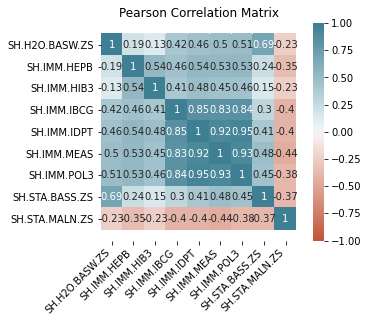

Removed Correlated Columns: {'SH.IMM.IDPT', 'SH.IMM.POL3', 'SH.IMM.MEAS'}


In [22]:
######################## Remove correlated Features
correlated_features = set()
# calculate Pearson correlation coefficient
corr = df_immu_hyg_underweight.corr()
print(corr['SH.STA.MALN.ZS'].sort_values(ascending=False))
print('===============================================================')
ax = sns.heatmap(
    corr,
    annot=True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.title('Pearson Correlation Matrix')
# plt.tight_layout()
plt.show()

for i in range(len(corr .columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.8:
            colname = corr.columns[i]
            correlated_features.add(colname)
print('Removed Correlated Columns:', correlated_features)
print('===============================================================')
X.drop(labels=correlated_features, axis=1, inplace=True)

Average accuracy of LogisticRegression is 0.6944444444444444
Accuracy of each fold:  [0.7027027  0.72972973 0.72972973 0.67567568 0.45945946 0.7027027
 0.75       0.75       0.77777778 0.66666667]
Accuracy of the current fold:  0.6939890710382514
Average accuracy of GaussianNB is 0.691966966966967
Accuracy of each fold:  [0.56756757 0.75675676 0.64864865 0.67567568 0.51351351 0.72972973
 0.75       0.86111111 0.77777778 0.63888889]
Accuracy of the current fold:  0.6912568306010929
Average accuracy of XGBClassifier is 0.7023273273273274
Accuracy of each fold:  [0.75675676 0.7027027  0.72972973 0.7027027  0.45945946 0.81081081
 0.63888889 0.77777778 0.72222222 0.72222222]
Accuracy of the current fold:  0.7021857923497268
Average accuracy of SVC is 0.7028528528528529
Accuracy of each fold:  [0.62162162 0.7027027  0.75675676 0.67567568 0.45945946 0.75675676
 0.75       0.86111111 0.77777778 0.66666667]
Accuracy of the current fold:  0.7021857923497268
Average accuracy of KNeighborsClassifi

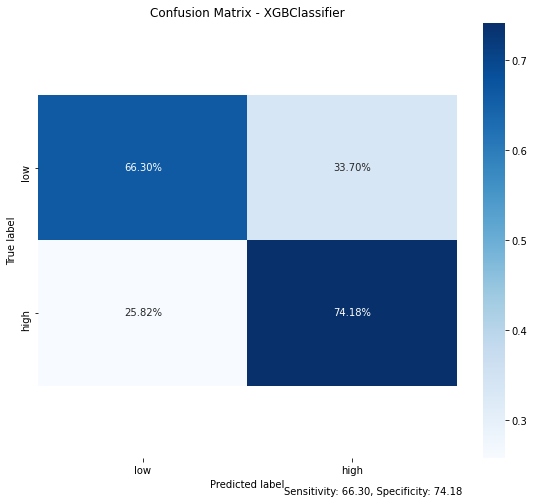

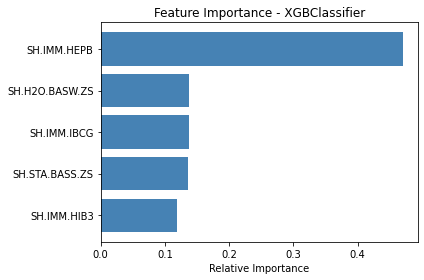

              precision    recall  f1-score   support

        high       0.72      0.66      0.69       184
         low       0.69      0.74      0.71       182

    accuracy                           0.70       366
   macro avg       0.70      0.70      0.70       366
weighted avg       0.70      0.70      0.70       366

Confusion matrix for  KNeighborsClassifier :  [[137  47]
 [ 55 127]]
Sensitivity :  74.45652173913044
Specificity :  69.78021978021978


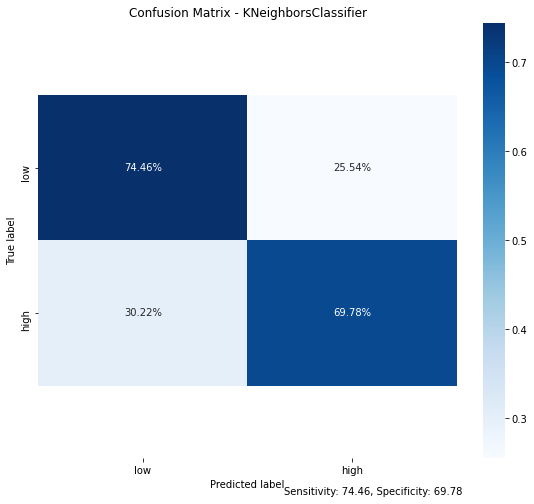

              precision    recall  f1-score   support

        high       0.71      0.74      0.73       184
         low       0.73      0.70      0.71       182

    accuracy                           0.72       366
   macro avg       0.72      0.72      0.72       366
weighted avg       0.72      0.72      0.72       366

Confusion matrix for  DecisionTreeClassifier :  [[134  50]
 [ 47 135]]
Sensitivity :  72.82608695652173
Specificity :  74.17582417582418


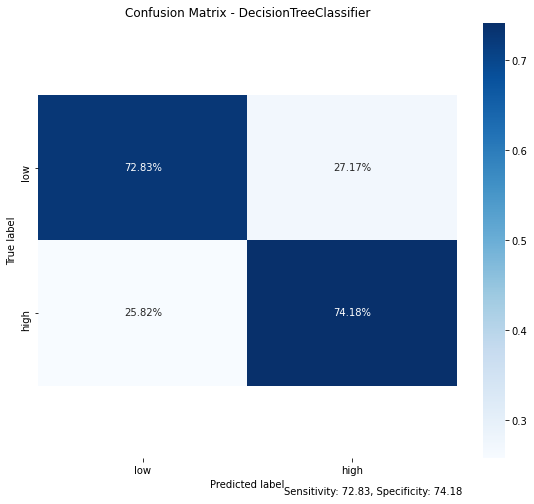

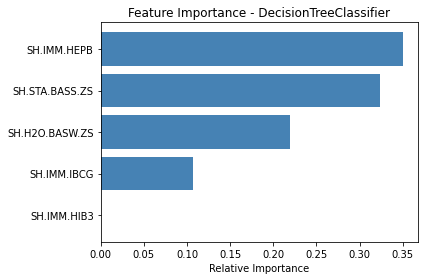

              precision    recall  f1-score   support

        high       0.74      0.73      0.73       184
         low       0.73      0.74      0.74       182

    accuracy                           0.73       366
   macro avg       0.74      0.74      0.73       366
weighted avg       0.74      0.73      0.73       366



In [23]:
########################################################################################################################################
##################### MODELS ######################
classifiers =[]
clf_logit = LogisticRegression()
classifiers.append(clf_logit)
clf_nb = GaussianNB()
classifiers.append(clf_nb)
clf_xgb = xgboost.XGBClassifier()
classifiers.append(clf_xgb)
clf_svm = sklearn.svm.SVC()
classifiers.append(clf_svm)
clf_knn = KNeighborsClassifier(n_neighbors=13)
classifiers.append(clf_knn)
clf_rf = RandomForestClassifier(random_state=0)
classifiers.append(clf_rf)

clf_accuracies = {}
############## Fine-tune KNN
# # try K=1 through K=25 and record testing accuracy
# k_range = range(1, 26)
# # We can create Python dictionary using [] or dict()
# scores = []
# # We use a loop through the range 1 to 26
# # We append the scores in the dictionary
# for k in k_range:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     clf_knn_optimized = KNeighborsClassifier(n_neighbors=k)
#     scores.append(cross_val_score(estimator=clf_knn_optimized, X=X, y=y, cv=10).mean())
# print(scores)
# plt.plot(k_range, scores)
# plt.xlabel('Value of K for KNN')
# plt.show()

################################## Fine-tune Decision Tree
# Define the parameter values that should be searched
# criterion = ['gini', 'entropy']
# max_depth = [4, 6, 8, 12]
# parameters = dict(criterion=criterion, max_depth=max_depth)
#
# # instantiate the grid
# dtc = DecisionTreeClassifier(random_state=0)
# grid = GridSearchCV(dtc, parameters, cv=10, scoring='accuracy')
# # fit the grid with data
# grid.fit(X, y)
# classifiers.append(grid.best_estimator_)
# print(grid.best_estimator_)
########################## Fine-tuned Decision tree using Grid Search
classifiers.append(DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best'))

############### Function to plot confusion matrix
def plot_cm(model_name, df_cm):
    plt.figure(figsize = (8,7))
    sns.heatmap(df_cm/ df_cm.sum(axis=1)[:, np.newaxis], annot=True,fmt='.2%', cmap='Blues', xticklabels=['low','high'], yticklabels=['low','high'])
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])*100
    print('Sensitivity : ', sensitivity)
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])*100
    print('Specificity : ', specificity)
    plt.title('Confusion Matrix - ' + model_name )
    plt.figtext(0.5, 0.01, 'Sensitivity: {:.2f}, Specificity: {:.2f}'.format(sensitivity, specificity))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

######### Plot Feature Importance
def plot_feature_importance(model):
    try:
        model.fit(X, y)
        importance = model.feature_importances_
        features = X.columns
        indices = np.argsort(importance)
        plt.title('Feature Importance - ' + model.__class__.__name__)
        plt.barh(range(len(indices)), importance[indices], color='steelblue', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        pass
#############################################################
# Calculate cross-validation scores
for clf in classifiers:
    all_accuracies = cross_val_score(estimator=clf, X=X, y=y, cv=10)
    print("Average accuracy of %s is %s"%(clf.__class__.__name__, all_accuracies.mean()))
    print('Accuracy of each fold: ', all_accuracies)
    y_pred = cross_val_predict(clf, X, y, cv=10)
    accuracy = accuracy_score(y, y_pred)
    print('Accuracy of the current fold: ', accuracy)
    clf_accuracies[clf.__class__.__name__] = accuracy
    print('===============================================================')
# print the sorted classifier accuracies
sorted_accuracies = sorted(clf_accuracies.items(), key=lambda item: item[1], reverse=True)
print('==================== Sorted Accuracies =================')
for k, v in sorted_accuracies:
    print(k, " ", v)

print('===============================================================')
top_3_accuracies = dict(sorted_accuracies[:3])

#### Calculate Confusion matrix and Feature Importance for Top 3 classifiers
for clf in classifiers:
    if clf.__class__.__name__ in top_3_accuracies.keys():
        y_pred = cross_val_predict(clf, X, y, cv=10)
        cm = confusion_matrix(y, y_pred)
        print('Confusion matrix for ', clf.__class__.__name__ , ': ', cm)
        plot_cm(clf.__class__.__name__, cm)
        plot_feature_importance(clf)
        print(classification_report(y, y_pred))
        print('===============================================================')

Area under the ROC curve for SVC: 0.769529
Area under the ROC curve for Descision Tree: 0.607889
Area under the ROC curve for KNN: 0.786655


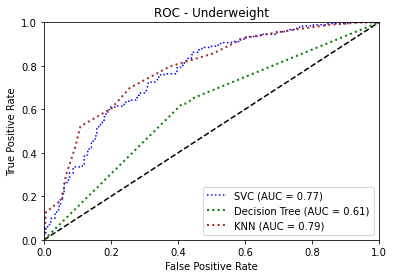

In [24]:
####################### Compute ROC curve and area the curve
## ROC Curve for SVC
probas_ = cross_val_predict(sklearn.svm.SVC(probability=True), X, y, cv=10, method="predict_proba")
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y, probas_[:, 1], pos_label='low')
roc_auc_svc = auc(fpr_svc, tpr_svc)
print("Area under the ROC curve for SVC: %f" % roc_auc_svc)

# Plot ROC curve
plt.clf()
plt.plot(fpr_svc, tpr_svc, "b:", label='SVC (AUC = %0.2f)' % roc_auc_svc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Underweight')
plt.legend(loc="lower right")

######### ROC Curve Decision Tree
y_prob_pred = cross_val_predict(DecisionTreeClassifier(random_state=0), X, y, cv=10, method="predict_proba")
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y, y_prob_pred[:, 1], pos_label='low')
roc_auc_dt = auc(fpr_dt, tpr_dt)
print("Area under the ROC curve for Descision Tree: %f" % roc_auc_dt)
plt.plot(fpr_dt, tpr_dt, linestyle=':', color='green', linewidth=2, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)
plt.legend(loc="lower right")

################ ROC Curve KNN
y_prob_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=13), X, y, cv=10, method="predict_proba")
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y, y_prob_pred[:, 1], pos_label='low')
roc_auc_knn = auc(fpr_knn, tpr_knn)
print("Area under the ROC curve for KNN: %f" % roc_auc_knn)
plt.plot(fpr_knn, tpr_knn, linestyle=':', color='brown', linewidth=2, label='KNN (AUC = %0.2f)' % roc_auc_knn)
plt.legend(loc="lower right")
plt.show()
##################################